## Setup and load data

In [77]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 100)
sns.set_context('talk')

sns.set_style('darkgrid', {'patch.edgecolor' : 'none', 'patch.force_edgecolor' : False})

In [ ]:
# Review styles
sns.axes_style()

In [39]:
# Load the health data
df = pd.read_csv('case_study.csv', index_col = 0, low_memory = False)

In [40]:
# Clean the column names to be pythonic

def clean_col(cname):
    out = cname.lower()
    out = out.replace(' ', '_')
    return out

df.rename(clean_col, axis = 1, inplace = True)

### Basic dataset examination

In [ ]:
df.sample(10)

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
df._state.value_counts()

## Subset your dataframe to only include the states in the tri-state area (NJ, CT, NY)

In [41]:
tristate_area_FIPS = [36, 34, 9] # NY, NJ, CT

# No effect as the data has already been subsetted to save disk-space and loading-time
df._state = df._state.astype(int)
df = df.query('_state == @tristate_area_FIPS')

# Human readable states
df['state'] = df['_state'].replace({9 : 'CT', 34 : 'NJ', 36 : 'NY'})

## Examine Physical Health

**PHYSHLTH** is the column we are interested in for this analysis, so let's start to investigate the column. Since we have a data cookbook, a.k.a. data dictionary) we want to start there before looking at the code. 

In [19]:
df.physhlth = df.physhlth.astype(int)

In [ ]:
df.physhlth.describe()

In [ ]:
df.physhlth.value_counts(dropna = False)

In [42]:
# Recode based on the codebook
df.physhlth = df.physhlth.replace({88:0, 77:np.nan, 99:np.nan})

In [ ]:
df.physhlth.describe()

In [ ]:
df.physhlth.value_counts(dropna = False)

## 2. Generate the descriptive statistics

Now that our target variable is cleaned up lets calculate the descriptive statistics, generate a graph that quickly shows those statistics, and generate a gprah shows the histogram of the data.

In [63]:
# Convenience alias
health = 'physhlth'

###### Boxplot to show summary statistics

In [78]:
%%capture
fig, ax = plt.subplots()
sns.boxplot(y = health, data = df, linewidth = 0.2, ax = ax);
ax.set_title('Number of days sick');
ax.set_ylabel('');

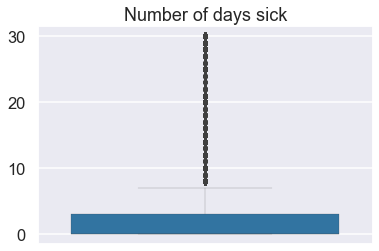

In [79]:
fig

###### Dist plot to show distribution in detail

In [80]:
%%capture
fig, ax = plt.subplots()
sns.distplot(df.physhlth.dropna(), ax = ax)
ax.set(title = 'Relative frequency of sick days per month', xlabel = 'Number of sick days', ylabel = 'Relative frequency')

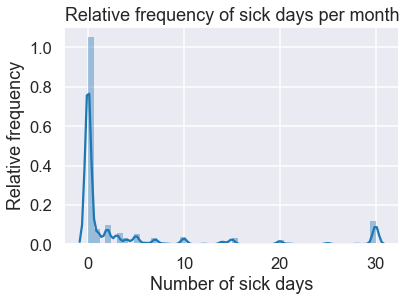

In [81]:
fig

## 3. Generate a graphic that compares the average number of sick days for each state. 

In [98]:
%%capture
fig, ax = plt.subplots()

data = df.groupby('state')['physhlth'].mean()
sns.barplot(x = data.index, y = data, ax = ax)
ax.set(title = 'Average number of sick days per state', xlabel = 'State', ylabel = 'Average sick days per month')

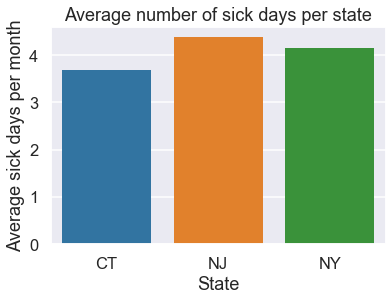

In [99]:
fig

## 4. Turn the number of sick days into a classification of of chronically sick people.  

Chronically sick people account for a significant proportion of the costs for health insurers. If we can identify what leads people to be chronically sick, we can address them with specific treatments.



In [101]:
q3  = df.physhlth.quantile(0.75)
iqr = df.physhlth.quantile(0.75) - df.physhlth.quantile(0.25)
outlier_cutoff = q3 + iqr * 1.5

## 5. Create a graphic that compares the percentage of people labeled as 'sick' in each state. 

In [104]:
df['sick'] = df.physhlth > outlier_cutoff

In [107]:
freq_table = pd.crosstab(df.state, df.sick, normalize='index')

In [108]:
# This is equivalent:
# freq_table = df.groupby(['state', 'sick'])['state'].count().unstack().apply(lambda row : row / row.sum(), axis = 'columns')

In [113]:
%%capture
fig, ax = plt.subplots()
sns.barplot(freq_table.index, freq_table[True], ax = ax)
ax.set(title = 'Percentage of people who are chronically sick by state'
      ,xlabel = 'State'
      ,ylabel = 'Percentage of respondents\nthat are chronically sick');

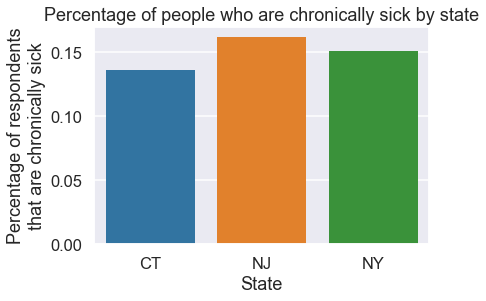

In [114]:
fig

## 6. Independent Variables (categorical)
Let’s take the column SMOKDAY2 and start to prepare it so that we can see how it is possibly correlated to PHYSHLTH.
1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Generate a graphic that compares the physical health of the different groups of ‘smokers’.

In [116]:
df.smokday2.value_counts(dropna = False)
df.smokday2 = df.smokday2.astype(int, errors = 'ignore')
df.smokday2 = df.smokday2.replace({7 : np.nan, 9 : np.nan, 1 : 'Every Day', 2 : 'Some Days', 3 : 'No Days'})
df.smokday2.value_counts(dropna = False)

NaN          20795
No Days       9703
Every Day     2676
Some Days     1371
Name: smokday2, dtype: int64

In [26]:
df.smokday2.describe()

count       13750
unique          3
top       No Days
freq         9703
Name: smokday2, dtype: object

In [131]:
%%capture
freq_table = pd.crosstab(df.smokday2, df.state, normalize = 'columns').applymap(lambda f : f * 100).stack().reset_index()
fig, ax = plt.subplots()
sns.barplot(x = 'smokday2', y = 0, hue = 'state', data = freq_table, ax = ax)
ax.set(title = 'Percentage with smoking history in each state', xlabel = 'Smoking History', ylabel = 'Percentage responding in the state')

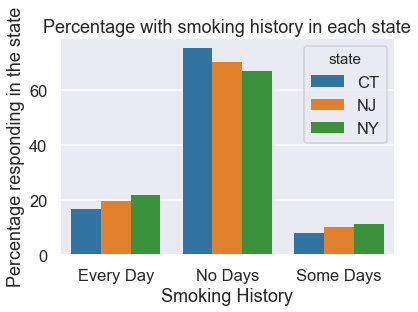

In [132]:
fig

In [206]:
binned_health = pd.cut(df.physhlth, [0,1,5,10,15,20,25,30,31], right = False)
data = pd.crosstab(binned_health, df.smokday2, normalize = 'columns').stack().reset_index()

In [151]:
%%capture
fig, ax = plt.subplots(figsize = (8,8))
sns.barplot(x = health, y = 0, hue = 'smokday2', data = data, ax = ax);
ax.set(xlabel = 'Range of sick days', ylabel = 'Frequency by smoking status', title = 'Health distribution by smoking status')

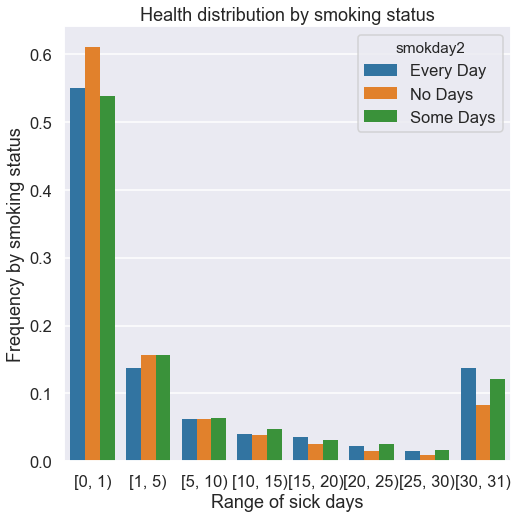

In [152]:
fig

## 7. Independent Variables (continuous):

Now let's look at a continuous variable (ALCDAY5) and see how that might impact a person's health. 

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Calculate the correlation coefficient between `PHYSHLTH` and `ALCDAY5`.
5. Generate a graphic that shows the possible relationship between `PHYSHLTH` and `ALCDAY5`.

In [ ]:
df.alcday5.describe()

In [154]:
def clean_alcday5(response):
    if np.isnan(response):
        return np.nan
    elif response < 100: # Make the function idempotent for convenience
        return response
    elif 100 < response < 200:
        return (response - 100) / 7 * 30
    elif 200 < response < 300:
        return response - 200
    elif response == 777:
        return np.nan
    elif response == 888:
        return 0
    elif response == 999:
        return np.nan
    else:
        return np.nan
        

In [155]:
df.alcday5 = df.alcday5.map(clean_alcday5)

In [ ]:
df.alcday5.describe()

In [162]:
%%capture
fig, ax = plt.subplots()
sns.distplot(df.alcday5, bins = 31, ax = ax)
ax.set(xlabel = 'Number of days drinking in the prior 30'
      ,ylabel = 'Relative Frequency'
      ,title  = 'Distribution of drinking days')

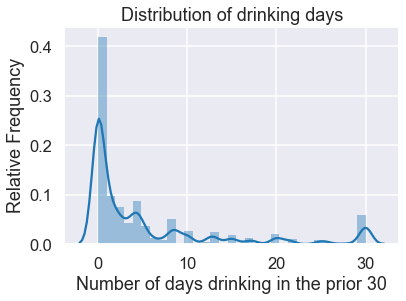

In [163]:
fig

In [49]:
# df.groupby('state').aggregate({'alcday5':['mean', 'std']})

alcday5          
           mean       std
state                    
CT     6.146279  8.808158
NJ     5.014878  8.160134
NY     5.213151  8.183824

In [172]:
%%capture
data = df.groupby('state')['alcday5'].mean().reset_index()
fig, ax = plt.subplots()
sns.barplot(x = 'state', y = 'alcday5', data = data, ax = ax)
ax.set(xlabel = 'State'
      ,ylabel = 'Average number of days\ndrinking in the last 30'
      ,title  = 'Drinking by state')

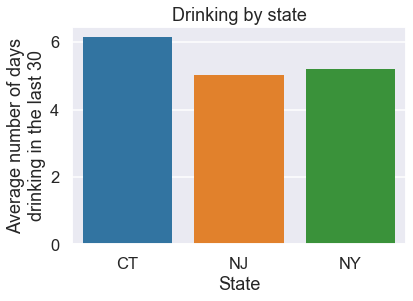

In [173]:
fig

In [204]:
%%capture
fg = sns.lmplot('alcday5', 'physhlth', data = df, x_jitter = 2, y_jitter = 2
               , scatter_kws = {'edgecolors' : 'none', 's' : 1}
               , ci = 95)
ax = fg.facet_axis(0,0)
ax.set(xlabel = 'Number of days drinking', ylabel = 'Number of sick days', title = 'Health by drinking')

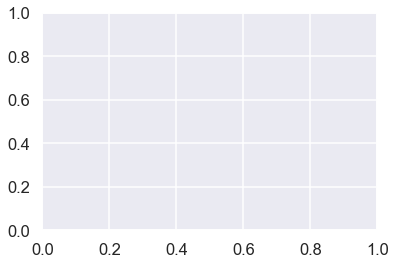

In [205]:
fig

## 8. Additional variables: Choose two additional survey items you would like to investigate do steps  6 or 7 for those variables.

In [36]:
# your code here

## 9. Based on your initial data exploration, what are some hypotheses of what affects a person's health that you would like to further investigate?

Type out your initial hyptotheses below:

1. 

2. 

3.  

## Bonus: Create some cool graphics.  

In [214]:
%%capture
fig, ax = plt.subplots()
sns.violinplot(x='state', y=health, hue='smokday2',
               split=True, inner="quart",
               palette={'Every Day' : 'y', 'No Days' : 'b'},
               data=df.query('smokday2 != "Some Days"'),
               ax = ax)
ax.set(xlabel = 'State', ylabel = 'Number of days sick', title = 'Health comparison between smokers and non-smokers by state')

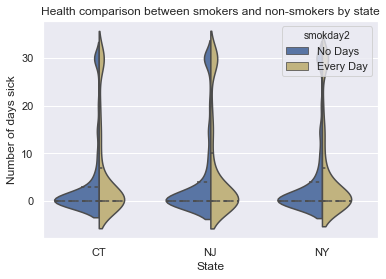

In [215]:
fig